In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd

from tensorflow import keras
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

/home/lg2958/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The data is monthly from Jan 1982 to Jan 2017, in total 421 months. We use data in the first 360 months to train the 1D convolution model, and use the last 360 months to validate the model. Since the first few months in the last 360 months is included in the training set, when computing the loss, we only consider the remaining 61 months which never appear during the training process.

In [9]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred[-61:] - y_true[-61:]), axis=-1))

In [4]:
DATA_DIR = '/home/lg2958/capstone/data'

dataset_names = {
    'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
    'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
    'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
    'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
    'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
    'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'
}

ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [5]:
merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])
df = merged_dataset.to_dataframe().reset_index()

In [9]:
SOM_DIR = '/home/lg2958/ocean-co2-absorption/notebooks/SOM/'
df_SOM = []
for i in range(1, 13):
    df_SOM.append(pd.read_csv(os.path.join(SOM_DIR, 'SOM_Month_{}.csv'.format(i))))

In [12]:
df.dropna(subset=['xlon', 'ylat','pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)
df.drop(columns=['TLONG', 'TLAT'], inplace=True)

Use k=15 clusters.

In [27]:
df['month'] = -1
for month in range(1, 13):
    df_som = df_SOM[month - 1]
    df_som['month'] = month
    df.loc[df.time.dt.month == month, 'month'] = month

In [30]:
df_SOM_combined = pd.concat(df_SOM)[['month', 'ylat', 'xlon', 'k=15']]

In [33]:
print(df_SOM_combined.shape)
df_SOM_combined.head()

(492420, 4)


,month,ylat,xlon,k=15
0,1,-77.5,179.5,10
1,1,-77.5,180.5,10
2,1,-77.5,181.5,10
3,1,-77.5,182.5,10
4,1,-77.5,183.5,10


In [48]:
df_combined = \
    df.merge(df_SOM_combined, left_on=['month', 'ylat', 'xlon'], right_on=['month', 'ylat', 'xlon'], how='left')

In [50]:
df_combined.loc[df_combined['k=15'].isnull(), 'k=15'] = -1

In [51]:
df_combined['k=15'] = df_combined['k=15'].astype(int)

In [ ]:
df_cluster = pd.concat([df_combined, pd.get_dummies(df_combined['k=15'], dtype=float)], axis=1)

In [53]:
df_cluster['s0'] = np.sin(df_cluster.ylat)
df_cluster['s1'] = np.sin(df_cluster.xlon) * np.cos(df_cluster.ylat)
df_cluster['s2'] = -np.cos(df_cluster.xlon) * np.cos(df_cluster.ylat)

In [56]:
df_cluster.head()

,time,xlon,ylat,pCO2,XCO2,SST,SSS,MLD,Chl,month,...,8,9,10,11,12,13,14,s0,s1,s2
0,1982-01-16 12:00:00,0.5,-69.5,256.390077,340.848541,-1.552322,33.641834,12.729663,1.128493,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.375524,0.444338,-0.813355
1,1982-01-16 12:00:00,0.5,-68.5,262.338616,340.848541,-1.626047,33.667816,19.951666,0.900315,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.576990,0.391571,-0.716767
2,1982-01-16 12:00:00,0.5,-67.5,261.956626,340.848541,-1.607591,33.572289,19.510101,0.635458,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.999021,-0.021204,0.038813
3,1982-01-16 12:00:00,0.5,-66.5,262.739347,340.848541,-1.496069,33.424641,20.714338,0.420227,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.502557,-0.414484,0.758709
4,1982-01-16 12:00:00,0.5,-65.5,266.288585,340.848541,-1.207762,33.317802,20.579535,0.380468,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.455956,-0.426690,0.781051


In [57]:
df_cluster.to_csv('data_with_cluster.csv', index=False)

* Restart kernel otherwise there might be memory error.

In [4]:
df = pd.read_csv('data_with_cluster.csv').drop(columns=['month'])

In [5]:
df_train = df[df.time < '2012'].copy()
df_val = df[-df_train.shape[0]:].copy()
print(df_train.shape)
print(df_val.shape)

(14785200, 29)
(14785200, 29)


In [6]:
df_train.sort_values(by=['xlon', 'ylat', 'time'], inplace=True)
df_val.sort_values(by=['xlon', 'ylat', 'time'], inplace=True)

In [10]:
df_train.drop(columns=['time', 'xlon', 'ylat', 'k=15'], inplace=True)
df_val.drop(columns=['time', 'xlon', 'ylat', 'k=15'], inplace=True)

In [14]:
y_train = df_train.pop('pCO2').values
X_train = df_train.values
y_val = df_val.pop('pCO2').values
X_val = df_val.values

In [22]:
np.save('y_train', y_train)
np.save('X_train', X_train)
np.save('y_val', y_val)
np.save('X_val', X_val)

* Restart kernel otherwise there might be memory error.

In [3]:
y_train = np.load('y_train.npy')
X_train = np.load('X_train.npy')
y_val = np.load('y_val.npy')
X_val = np.load('X_val.npy')

In [4]:
num_grids = 41070
X_train = np.array(np.array_split(X_train, num_grids))
y_train = np.array(np.array_split(y_train, num_grids))
X_val = np.array(np.array_split(X_val, num_grids))
y_val = np.array(np.array_split(y_val, num_grids))

In [6]:
model = keras.Sequential()
model.add(keras.layers.Conv1D(64, 3, activation='relu', input_shape=(360, 24)))
model.add(keras.layers.Conv1D(64, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(3))
model.add(keras.layers.Conv1D(128, 3, activation='relu'))
model.add(keras.layers.Conv1D(128, 3, activation='relu'))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(360))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 358, 64)           4672      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 356, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 118, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 116, 128)          24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 114, 128)          49280     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
__________

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', rmse])

In [11]:
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_val, y_val))

Train on 41070 samples, validate on 41070 samples
Epoch 1/20
41070/41070 [==============================] - 253s 6ms/step - loss: 4149.9149 - mean_squared_error: 4149.9149 - rmse: 55.2440 - val_loss: 1723.5931 - val_mean_squared_error: 1723.5931 - val_rmse: 35.8030
Epoch 2/20
41070/41070 [==============================] - 224s 5ms/step - loss: 3367.2741 - mean_squared_error: 3367.2741 - rmse: 50.0770 - val_loss: 2368.2022 - val_mean_squared_error: 2368.2022 - val_rmse: 44.7322
Epoch 3/20
41070/41070 [==============================] - 223s 5ms/step - loss: 2786.7764 - mean_squared_error: 2786.7764 - rmse: 45.7852 - val_loss: 1503.2673 - val_mean_squared_error: 1503.2673 - val_rmse: 33.9141
Epoch 4/20
41070/41070 [==============================] - 225s 5ms/step - loss: 2415.3769 - mean_squared_error: 2415.3769 - rmse: 42.6271 - val_loss: 1082.7558 - val_mean_squared_error: 1082.7558 - val_rmse: 27.2540
Epoch 5/20
41070/41070 [==============================] - 224s 5ms/step - loss: 2067.2

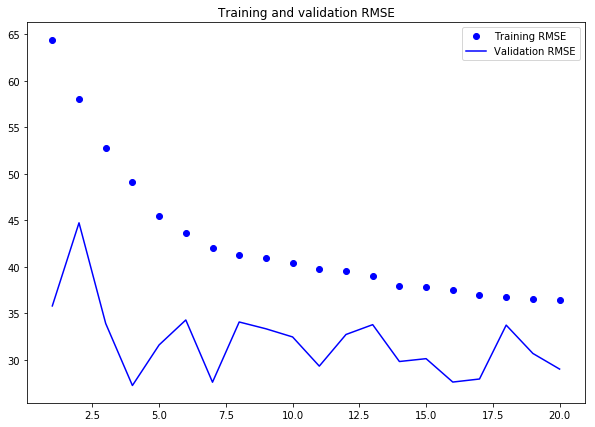

In [12]:
epochs = np.arange(1, 21)
train_mse = history.history['mean_squared_error']
val_rmse = history.history['val_rmse']

plt.figure(figsize=(10, 7))
plt.plot(epochs, np.sqrt(train_mse), 'bo', label='Training RMSE')
plt.plot(epochs, val_rmse, 'b', label='Validation RMSE')
plt.title('Training and validation RMSE')
plt.legend()

plt.savefig('RMSE_with_clusters.png', dpi=300)
plt.show()